
<center><h1><b>Methodology of Gene Prediction</b></h1></center>
<center><h3><i>By Davis Garwood and Kevin Wen</i></h3></center>


---

<div class="alert alert-success">
    <center><h1>Introduction</h1></center>
</div>

Computational algorithms for [gene prediction](https://en.wikipedia.org/wiki/Gene_prediction) are designed for the identification, analysis, and annotation of coding regions of an uncharacterized genome. This ranges from finding the nucleotide positions a gene begins and ends to predicting the functional aspects of said gene [1]. Though we will focus on genes that encode proteins, gene prediction can also be applied to regions that produce RNA molecules [2].

<div class="alert alert-block alert-danger">
Before running the cells below make sure to have installed and imported all of the dependencies. 
</div>

In [ ]:
!pip install orfipy
!pip install hmmlearn

In [ ]:
from hmmlearn import hmm
import orfipy_core as orfipy
import numpy as np
import random
import copy

<h2> Approaches to Gene Prediction </h2>

Gene prediction algorithms can be placed in one of two categories. 

<h3> Similarity Searches: </h3>

This approach relies on local alignment (Smith-Waterman) and global alignment (Needleman-Wunsch) algorithms. This alignment can be done at either the DNA or protein level. A sequence with high levels of homoglogy to a known gene is almost certainly a gene under the assumption that functional regions of genes are evolutionarily conserved. By establishing homology we can also infer the new gene's function. Of course, if a hypothetical gene is not sufficiently homologous to any known gene then this approach will fail. On average this is expected to happen 50% of the time [1]. 

<div class="alert alert-block alert-info">
The best way to perform similarity searches is <a href=https://blast.ncbi.nlm.nih.gov/Blast.cgi> BLAST </a> for direct access to many large gene databases.
</div>

<h3> <i>Ab initio</i> Methods: </h3>

This class of methods uses genetic structures to detect genes. Specifically, singal sensors such as start and stop codons and content sensors which reflect the codon usage of a species. For this reason, many *ab initio* models are specifically constructed to work best on a subset of organisms. Many different *ab initio* techniques are used such as dynamic programming, linear discriminant analysis, neural networks, and hidden Markov models [1]. Though perhaps the simplest *ab initio* method is that of an open reading frame (ORF) finder which relies solely on start and stop codons as signal sensors. While these models might need to be trained on existing data, once they are operational they can predict genes within some error threshold independent of known homologies. Though the hypothetical genes found by these methods can still be examined with similarity searches to test their legitimacy. Here we will focus on the hidden Markov model (HMM) as it is a particular prevalent and successful technique in the field of gene prediction. In addition, the creation and use of an ORF finder as a means of identifying preliminary gene candidates will be demonstrated. 

<h2> Gene Prediction By Taxonomic Domain </h2>

Gene prediction is not constant between organisms due to differing genetic structures. Notably, eukaryotic genes are far more complex than those of prokaryotes (and also archaea). Below we considere the differences between the [genetic structure](https://en.wikipedia.org/wiki/Gene_structure) found in these two domains.  

<h3> In Prokaryotes: </h3>

**Genetic Structure** Prokaryotic genes are often grouped together in structures called operons. Each gene in an operon is regulated by the same promoter or repressor and transcribed to the same strand of mRNA. These genes are continuous meaning that the next in-frame stop codon after a start codon is guaranteed to be the end of the gene. Additionally, upstream of the start codon there is a ribosomal binding site (RBS) which is needed to initialize translation. 

<center>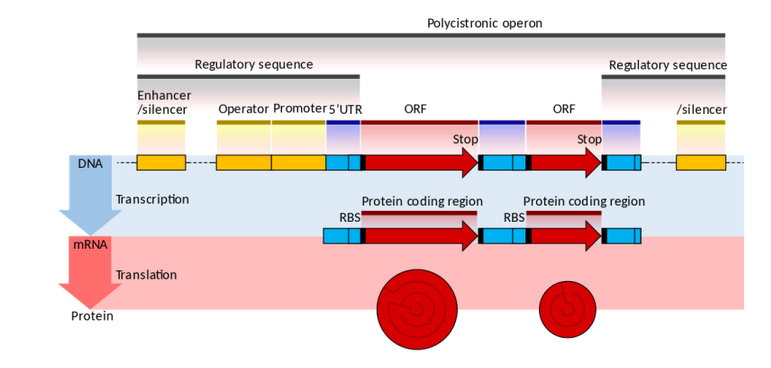 </center>

<center> <b> <a href="https://en.wikipedia.org/wiki/Gene_structure">Figure 1: </a></b> Structure of a prokaryotic operon. </center>

**Approach** 
Gene prediction in prokaryotic organisms can be performed at its most basic level by scanning a genome for ORFs. This is due to the lack of introns. In other words, we do not have to worry if a stop codon is part of the coding region or not. Combined with a search for other genetic motifs like promoters or ribosomal binding sites, good accuracy can be achieved by simply scanning over these ORFs. Though, because of the great diversity across prokaryotes, gene prediction is by no means a completely trivial process [3].

<h3> In Eukaryotes: </h3> 

**Genetic Structure** Eukaryotic genes are subject to much more regulation than their prokaryotic counterparts and are not organized into operons. Most imporantly they have introns and exons. Flanking an intron are splice sites which facilitate the splicing of exons together. These introns can be long and make it difficult to identify an eukaryotic ORF.

<center></center>

<center> <b> <a href="https://en.wikipedia.org/wiki/Gene_structure">Figure 2: </a></b> Structure of an eukaryotic gene. </center>

**Approach** The more complex structure of eukaryotic genomes requires a more intricate *ab initio* method than just a ORF scanner for gene prediction. Typically, this means training and using a hidden Markov model. For this model to work it must be sufficiently complex to capture the statistical differences between different regions of a gene and accurately model their length distributions [4]. Even then such a model can produce false positive results. This is to say that gene prediction in eukaryotic organisms is very hard. 

<div class="alert alert-success">
    <center> <h1> Open Reading Frame Identification </h1> </center>
</div>

<h3> Definining an ORF </h3>

An open reading frame exists when a start codon is eventually followed by an in-frame stop codon. Along a strand of DNA there are three possible reading frames since there are three bases in a codon. So in total there are six reading frames since ORFs can be on the complementary DNA strand as well. Note that in eukaryotes the stop codon only counts if it occurs in an exon which we do not know beforehand.   

<center> 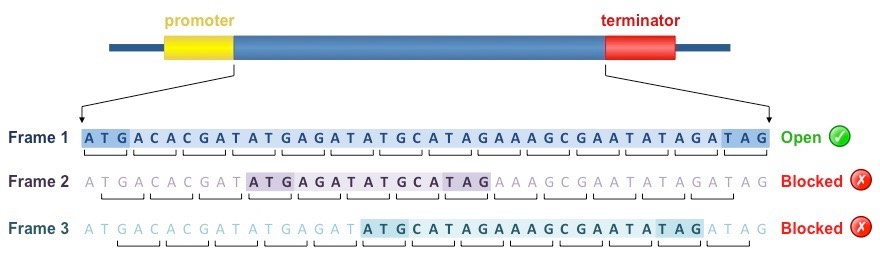 </center>

<center> <b> <a href="https://ib.bioninja.com.au/options/untitled/b2-biotechnology-in-agricul/gene-identification.html"> Figure 3: </a> </b> The 3 reading frames on a single strand of DNA (no introns considered). Only the first is a valid ORF. </center>

<h3> Implementing an ORF Finder </h3>

Below is code for a simple ORF finder. It finds and reports ORFs on both the input 5' to 3' strand and the complementary 3' to 5' strand. This is done by scanning the three reading frames along both strands and marking the start and stop codons that are in-frame. Since the longest ORFs are statistically most likely to be genes we opt to ignore nested ORFs and also provide an option to remove overlapping ORFs only keeping the longest in either instance. However, it should be noted that these assumptions don't always work as regulatory regions preceding a shorter ORF might make it the true gene compared to a longer ORF, and in actuality, prokaryotic genes overlap about 29% of the time [5].

<div class="alert alert-block alert-info">
Here "+" refers to the ORFs on the 3'-5' strand while "-" refers to ORFs on the 5'-3' strand. Also, keep in mind that reading a strand 5'-3' gives the ORFS on the complement of that strand since that is the strand transcribed by RNA polymerase. 
</div>

In [ ]:
def get_sequence(seq_file):
    '''
    Processes FASTA file to load sequence. 

    seq_file : string 
        FASTA file path.
    '''

    seq_file= open(seq_file, 'r')
    seq= seq_file.read()
    seq= seq.split('\n')[1:]
    seq = ''.join(seq)
    return seq

def get_complement(seq):
  '''
  Creates complementary DNA sequence. 

  seq : string 
      DNA sequence.
  '''

  complement= ''
  for s in seq:
    if s=='T':
      complement+='A'
    elif s=='A':
      complement+='T'
    elif s=='C':
      complement+='G'
    elif s=='G':
      complement+='C'
    else:
      raise ValueError('Not a Nucleotide')
  return complement[::-1]

def codon_itr(s):
    '''
    Iterator that goes through DNA sequence a codon at a time in one 
    reading frame. 

    s : string 
      DNA sequence. 
    '''

    i=0
    while len(s)-i >= 3:
        yield s[i:i+3]
        i+=3

def print_ORF(seq, range, complement=False):
  '''
  Prints DNA sequence corresponding to an ORF. 

  seq : str 
    DNA sequence (5'-3')
  range : <int, int> 
    ORF interval 
  complement : bool 
    Is this an ORF on complementary strand? 
  '''

  if not complement:
    print(seq[range[0]:range[1]])
  else:
    seq= get_complement(seq[range[0]:range[1]])
    print(seq)

In [ ]:
class simple_ORF_finder:

  def __init__(self, min_len=0, start_codons=('ATG','GTG','TTG'), stop_codons=('TAG','TAA','TGA')):
    '''
    min_len : int  
        The minimum length an ORF should be.
    start_codons : list<string> 
        All codons to treat as start codons. 
    stop_codons : list<string> 
        All codons to treat as stop codons. 
    '''

    self.start_codons= start_codons
    self.stop_codons= stop_codons  
    self.min_len= min_len

  def __call__(self, seq, as_file=True, no_overlapping_orfs=False, no_nested_orfs=False):
    '''
    Performs a simple scan of ORFs of some minimum length. If two ORFs overlap,
    the longest is taken to be the most likely to be a gene. If a larger index 
    comes first then the ORF is on the complementary strand. 

    seq : string 
        File path to sequence data (in FASTA format) or DNA strand. 
    as_file : bool
        Is this a file path? 
    no_overlapping_orfs : bool 
        Should overlapping ORFs be removed? Only the longest ORFs will be kept as these are statistically
        the most likely to be genes. 
    no_nested_orfs : bool
        Should nested ORFs (ORFs entirely within another ORF) be removed as they are less likely to be genes
        than the ORF encompassing it.
    '''

    ORFs= {} 
    seq = get_sequence(seq) if as_file else seq
    ORFs.update(self.seq_scan(seq,False))
    ORFs.update(self.seq_scan(seq,True))
 
    if no_nested_orfs:
      ORFs= self.remove_nested_orfs(ORFs)
    if no_overlapping_orfs:
      ORFs= self.remove_overlapping_orfs(ORFs)
    return ORFs
  
  @classmethod
  def remove_overlapping_orfs(cls, ORFs):
    '''
    Removes overlapping ORFs keeping only the longest. 

    ORFs : dict<tuple, string> 
      Dictionary of ORFs on both strands of DNA. 
    '''

    intervals= ORFs.keys()
    intervals= sorted(intervals, key=lambda x : abs(x[1]-x[0]) )[::-1]
   
    for n, interval in enumerate(intervals):
      for i in intervals[n+1:]:
        if (i[0]<=interval[0] and i[1]>=interval[0]) or (i[0]<=interval[1] and i[1]>=interval[0]):
          if i in ORFs:
            ORFs.pop(i)
    return ORFs

  @classmethod
  def remove_nested_orfs(cls, ORFs):
    '''
    Removes nested ORFs keeping only the longest. 

    ORFs : dict<tuple, string> 
      Dictionary of ORFs on both strands of DNA. 
    '''

    intervals= ORFs.keys()
    intervals= sorted(intervals, key=lambda x : abs(x[1]-x[0]) )[::-1]
   
    for n, interval in enumerate(intervals):
      for i in intervals[n+1:]:
        if (i[0]>=interval[0] and i[1]<=interval[1]):
          if i in ORFs:
            ORFs.pop(i)
    return ORFs

  def frame_scan(self, seq, frameshift=0, complement=False):
    '''
    Scans a DNA sequence in a single reading frame (assumes 5'-3')

    seq : string 
        DNA sequence to scan. Assumes 5'-3' direction.
    complement : bool 
        If the complement strand should be scanned. 
    frameshif : int 
      0, 1, or 2 used to set reading frame 
    '''

    if frameshift not in [0,1,2]:
      raise ValueError('Frameshift can only be 0, 1, or 2')

    ORFs= {}
    current_starts= []
    for i, codon in enumerate(codon_itr(seq[frameshift:])):
        if codon in self.start_codons:
          current_start= len(seq)-(3*i+frameshift) if complement else 3*i+frameshift
          current_starts.append(current_start)
        if current_starts and codon in self.stop_codons: 
          stop= len(seq)-(3*i+frameshift+3) if complement else 3*i+frameshift+3
          for start in current_starts:
            if abs(stop-start)>=self.min_len:
              if complement:
                ORFs[(stop,start)]= "-"
              else:
                ORFs[(start, stop)]= "+"
          current_starts= []
    return ORFs

  def seq_scan(self, seq, complement=False):
    '''
    Scans a DNA sequence for ORFs. Note internal start codons are ignored 
    because it is assumed the longest ORFs are most likely to be genes. 

    seq : string 
        DNA sequence to scan. Assumes 5'-3' direction.
    complement : bool 
        If the complement strand should be scanned. 
    '''
    ORFs= {} 
    if complement:
      seq= get_complement(seq)

    #Iterate through frame 1
    ORFs.update( self.frame_scan(seq, 0, complement) )

    #Iterate through frame 2
    ORFs.update( self.frame_scan(seq, 1, complement) )

    #Iterate through frame 3
    ORFs.update( self.frame_scan(seq, 2, complement) )

    return ORFs

Lets now load a test sequence. Here we use a plasmid from [*Salmonella enterica*](https://www.ncbi.nlm.nih.gov/nuccore/NC_011604) which is 10908bp long and contains 15 genes. All of these genes were identified computationally either through protein homology or using the program [GeneMarkS](http://exon.gatech.edu/GeneMark/genemarks.cgi) (an HMM). 

This file is in FASTA format (and we assume all input files will be in this format) which means the DNA sequence is written 5' to 3'. From which we will also make the complementary strand to scan over.

<div class="alert alert-block alert-danger">
Make sure the file path is correct. 
</div>

In [ ]:
#Test sequence paths
plasmid_file= 'salmonella_plasmid.fasta'
Ecoli_file= 'Ecoli_genome.fasta'

Nucleotide Range of Known Genes | Start Codon | Strand | Length
--- | --- | --- | ---
629-1392 | GTG | + | 763
1859-2326 | ATG | - | 467
2783-3169 | ATG | + | 386
3360-3716 | TTG | - | 356
3925-4608 | ATG | + | 683
4644-5594 | GTG | + | 950 
5665-5883 | ATG | + | 218
5892-6767 | ATG | + | 875
6813-7232 | GTG | - | 419 
7291-7995 | ATG | + | 704 
8117-8737 | TTG | + | 620 
8734-8913 | ATG | + | 179 
8995-9624 | ATG | + | 629
9645-9854 | ATG | + | 209 
9907-10908 | ATG | + | 1001

<center> <b>Table 1</b>: For reference there are 15 known genes as shown above. 
As can be seen the rare start codons GTG & TTG are used by some genes. However, this is known to be the case in many prokaryotic genomes. Note these ranges are indexed from 1 while our code is indexed from 0. </center>

<div class="alert alert-info">
Keep in mind that prokaryote genomes are circular not linear. Luckily, the FASTA file is prealigned in such a way that it ends on an ORF so we can treat it as linear and still find all ORFs. Though for arbitrary data we, of course, cannot assume this and would have to perform some preprocessing. 
</div>

In [ ]:
#Demonstrate Simple ORF Finder
find_orfs= simple_ORF_finder(600) 
ORFs= find_orfs(plasmid_file, no_overlapping_orfs=False, no_nested_orfs=True)

ORFs3to5, ORFs5to3= [], []
for key, strand in ORFs.items():
  if strand=='+':
    ORFs3to5.append(key)
  elif strand=='-':
    ORFs5to3.append(key)
print('ORFs on Given Strand:', sorted(ORFs3to5, key=lambda x : x[0]))
print('ORFs on Complementary Strand:', sorted(ORFs5to3, key=lambda x : x[0]))

Referring to the genes over 600bp long in Table 1, we can correctly find the exact location of 4 genes, predict the wrong start postition for another 4, miss 1 gene, and incorrectly predict 1 gene. This an accuracy of about ~44% which is not great, but also not terrible considering how simple this algorithm. 

NCBI also has a simple to use [ORF finder](https://www.ncbi.nlm.nih.gov/orffinder/) with this same sequence as a loadable example. However, since this site is connected to the NCBI database it also allows for easy BLAST searches which can be used to verify if an ORF is actually a gene through homology. 

<center>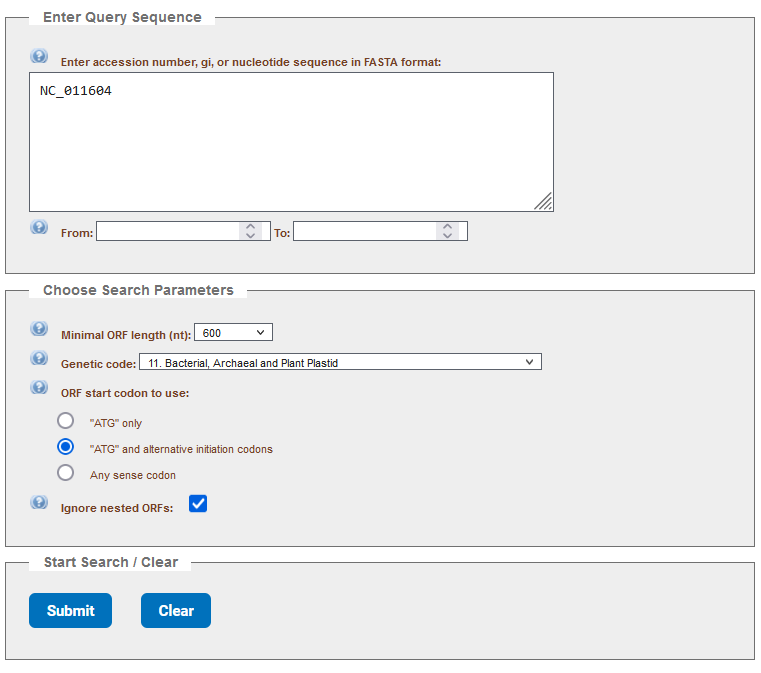</center>

<center>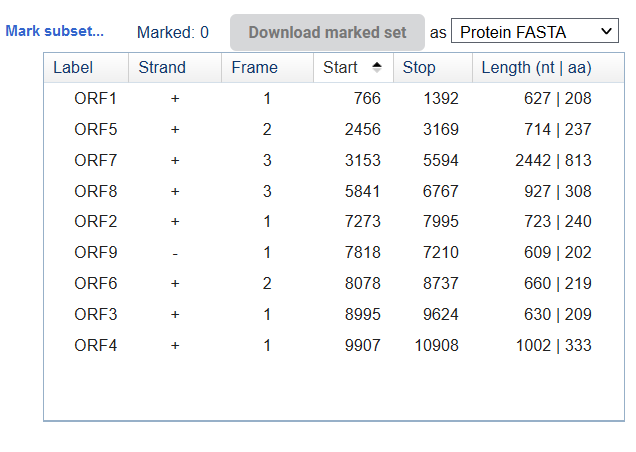</center>
<center> <b> Figure 3: </b> Comparing to are results we see that they match (taking into account that we index from 0 while NCBI indexes from 1) except for ORF1 & ORF6. However, this is just because NCBI considers CTG to be a valid start codon where as we stick to only the known start codons in this sequence. </center>

<h3> Using Orfipy </h3>

Alternatively, [orfipy](https://github.com/urmi-21/orfipy) is an efficient implementation of an ORF finder that can be easily used in Python code. To demonstrate this lets look at an [*E. coli* genome](https://www.ncbi.nlm.nih.gov/data-hub/assembly/GCF_000008865.2/) which is 5.6Mb long and contains ~5,000 protein coding genes. On top of orfipy we also build a simple motif scanner which will narrow down the number of possible ORFs by determining if the Shine-Dalgarno sequence, GAGG, (an RBS) is upstream of the start codons [6]. By refining our ORF finder this way, we can be more confident that the returned ORFs might be actual genes.

<div class="alert alert-info">
    Note that while the Shine-Dalgarno sequence is prevalent in <i>E. coli</i> not all <i>E. coli</i> genes use it. 
</div>


In [ ]:
class motif_finder:

  def __init__(self, motif, range):
    '''
    A simple motif finder

    motif : string 
      Motif to look for. 
    range : [int, int]
      Range to search upstream of the start codon.
    '''

    self.motif=motif
    self.range=range
  
  def __call__(self, seq, start, stop, description):
    '''
    Search for motif upstream of an ORF. Assumes linearity. 

    seq : string
      The sequence.
    start, stop : int
      Start & stop codon indices.
    description : string
      Description of ORF.
    '''

    if 'ORF_frame=-' in description:
      i1, i2= stop+self.range[0], stop+self.range[1] 
      i1= i1 if i1<len(seq) else len(seq)-1
      i2= i2 if i2<len(seq) else len(seq)-1
      sub_seq= get_complement( seq[i1:i2] )
    else:
      i1, i2= start-self.range[1], start-self.range[0]
      i1= i1 if i1>0 else 0 
      i2= i2 if i2>0 else 0
      sub_seq= seq[i1:i2]

    if self.motif in sub_seq:
      return True 
    return False

class ORFipy(simple_ORF_finder):

  def __init__(self, min_len=0, motif=None, start_codons=('ATG','GTG','TTG'), stop_codons=('TAG','TAA','TGA')):
    super().__init__(min_len, start_codons, stop_codons)
    self.motif= motif

  def __call__(self, seq, as_file=True, no_overlapping_orfs=False, no_nested_orfs=False):
    '''
    Performs a simple scan of ORFs of some minimum length. If two ORFs overlap,
    the longest is taken to be the most likely to be a gene. If a larger index 
    comes first then the ORF is on the complementary strand. 

    seq : string 
        File path to sequence data (in FASTA format) or DNA strand. 
    as_file : bool
        Is this a file path? 
    no_overlapping_orfs : bool 
        Should overlapping ORFs be removed? Only the longest ORFs will be kept as these are statistically
        the most likely to be genes. 
    no_nested_orfs : bool
        Should nested ORFs (ORFs entirely within another ORF) be removed as they are less likely to be genes
        than the ORF encompassing them.
    '''

    ORFs= {} 
    seq = get_sequence(seq) if as_file else seq
    ORFs.update(self.seq_scan(seq))
 
    if no_nested_orfs:
      ORFs= self.remove_nested_orfs(ORFs)
    if no_overlapping_orfs:
      ORFs= self.remove_overlapping_orfs(ORFs)
    return ORFs
  
  def seq_scan(self, seq):
    '''
    Scan a sequence using orfipy library.
    
    seq : string 
        DNA sequence to scan. Assumes 5'-3' direction.
    '''
    
    ORFs= {}
    for start, stop, strand, description in orfipy.orfs(seq,minlen=self.min_len,starts=self.start_codons,stops=self.stop_codons,strand='b',include_stop=True):
        if type(self.motif) is motif_finder:
          if self.motif(seq,start,stop,description):
            ORFs[(start, stop)]= description
        else:
          ORFs[(start, stop)]= description
    return ORFs

In [ ]:
#Demonstrate Orfipy w/ Motif Scan
m= motif_finder('GAGG',[6,30])
test_orfipy= ORFipy(100,m)
ORFs= test_orfipy(Ecoli_file, no_overlapping_orfs=False, no_nested_orfs=True)

print('Number of Likely ORFs Found:', len(ORFs))

<div class="alert alert-success">
    <center><h1> Hidden Markov Models of Genes </h1></center>
</div>

Now lets look at what HMMs are and how they can model genes. 

<h2> 1st Order HMM </h2>

An [HMM](https://en.wikipedia.org/wiki/Hidden_Markov_model) has an observed state that is a sequence of *L* observed substates 
\begin{equation}
\bf{x}= x_1x_2...x_L
\end{equation}
and a corresponding hidden state that is a sequence of *L* hidden substates. 
\begin{equation}
\bf{z}= z_1z_2...z_L
\end{equation}
Observed substates are assigned a symbol from the set *O* of size *M* ( for DNA *O* = {A,T,C,G} ) while hidden states are assigned a symbol from the set *H* of size *N*. Internally, though, all substates are referred to by an integer so they can be used as indices. 

Transitions between these hidden states follow a first order [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) (current state only depends on previous state) and transition probabilities between states are stored in a matrix we will denote *A* of shape *NxN*. In addition to this transition probability matrix, the HMM is fully determined by a vector of initial state probabilities, *π*, of length *N* and an emission probabilitiy matrix, *B*, of shape *NxM* that determines the emission probability of an observable state *n* when in hidden state *m*. To simplify the notation let $θ = (A,B,π)$.

From these parameters we can calculate the probability that an HMM will produce the observed sequence **x** given the underlying parameters

<div class="alert alert-warning">
\begin{equation}
P(\bf{x}, \bf{z} | \theta) = P(\bf{x} | \bf{z}, B)P(\bf{z} | A, \pi)
\end{equation}
</div> 

where
   
<div class="alert alert-warning">
\begin{equation}
P(\bf{x} | \bf{z}, B) = B(z_1,x_1)...B(z_L,x_L)
\end{equation}
    
\begin{equation}
P(\bf{z} | A, \bf{\pi})= \pi(z_1)A(z_1,z_2)...A(z_{L-1},z_L)
\end{equation}
</div>

This means that if we can construct a set of hidden states which model a gene we can calculate the probability that a certain DNA sequence is actually a gene, P(**x**|$\theta$). To determine this probability we could sum over the set of all hidden state sequences for the given observed state **x**. However, this is computationally inefficient and instead we will take a dyanmic programming approach using the [forward algorithm](https://en.wikipedia.org/wiki/Forward_algorithm). The expression becomes 

<div class="alert alert-warning">
\begin{equation}
P(\bf{x} | \theta ) = \sum_{k \in H} \alpha(L,k) 
\end{equation}
\begin{equation}
\alpha(l,k)= P(x_1...x_i,z_l=k|\theta)= \sum_{i \in H} \alpha(l-1,i)A(i,k)B(k,x_l)
\end{equation}
</div>

<div class="alert alert-info">
The time complexity of the forward algorithm is $O(LN^2)$ [7]. 
</div>

We can also search for the internal sequence of states, $z^*$, that maximizes this probability, $argmax_z P(\bf{z} | \bf{x}, \theta)$, to find the most likely structure of the gene (i.e. where exons & introns are located etc.).

As before, this is best solved using dynamic programming specificially the [Viterbi algorithm](https://en.wikipedia.org/wiki/Viterbi_algorithm). The maximum observation probability is given by 

<div class="alert alert-warning">
\begin{equation} 
P^*= max_k [ \gamma(L,k) ]
\end{equation}
</div>

where $\gamma$ is defined by 

<div class="alert alert-warning">
\begin{equation}
\gamma(l,k)=max_i [ \gamma(l-1,i)A(i,k)B(k,x_l) ]
\end{equation}
</div>

we then reconstruct the optimal sequence of hidden states by backtracing through the recursions that gave the maximum probability (similar to sequence alignment algorithms). An approach to calculate the most likely substate of z<sub>i</sub> also exits [7]. 

<h2> Creating a HMM model </h2>

A simple toy model of a eukaryotic gene is depicted below with *H* = {E1, E2, E3, I}. 
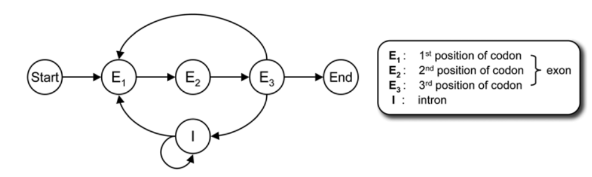

A single state is used to model an intron while three states are used for exons to account for different base statistics in codons. Additionally, there is a start and stop state [7]. For simplicity let's make these abstract representations of the promoter, 5' UTR, & start codon and stop codon & 3' UTR respectively. We also add a state *N* to represent non-coding regions that flank the gene. 

Instead of implementing this from scratch we can make use of the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/tutorial.html#available-models) Python library. Specifically, the [MultinomialHMM](https://hmmlearn.readthedocs.io/en/latest/api.html#hmmlearn.hmm.MultinomialHMM) class has all the components we need to successfully recreate the model above.

In [ ]:
def gen_random_seq(L, nt_only=True):
   '''
    Generates a random ORF. Expected to not be a gene.

    L : int 
      Length of sequence to generate.
    nt_only : bool
      Whether to include special BEGIN & END states.
   '''

   seq= []
   states= ['A','T','G','C'] if nt_only else ['A','T','G','C','BEGIN','END']
   for i in range(L):
     seq.append(random.choice(['A','T','G','C']))
   return seq

class HMM:

  def __init__(self, hidden_states, observable_states, A=None, B=None, pi=None, n_iter=1000):
    '''
    Initialize 1st Order HMM model. 

    hidden_states : list<string>
      List of hidden states. Determines n.
    Observable-states : list <string>
    A : ndarray
      Optional transition probabilities matrix.
    B : ndarray 
      Optional emission probabilities matrix.
    pi : ndarray
      Optional starting probabilities matrix.
    n_iter : int
      Number of iterations for training model parameters.
    '''

    if not hidden_states or not observable_states:
      raise ValueError('Must provide hidden and observable states')

    init_params= ''
    if pi is None:
      init_params+='s'
    if A is None:
      init_params+='t'
    if B is None:
      init_params+='e'
    self.n, self.m= len(hidden_states), len(observable_states)
    self.hidden_states, self.observable_states= hidden_states, observable_states
    self.HMM= hmm.MultinomialHMM(n_components=self.n, n_iter=n_iter, 
                                 params='ste', init_params=init_params, verbose=True)
    self.set_transmat(A)
    self.set_emissionprob(B) 
    self.set_startprob(pi) 

  def parse_input(self, x):
    '''
    Transforms list of observable state labels to integer labels.

    x : list<string> 
      List of observable states (denoted by their labels)
    '''

    seq= np.ndarray( (len(x),), dtype=int)
    for i, s in enumerate(x):
      seq[i]= self.observable_states.index(s)
    return seq.reshape(-1,1)

  def set_startprob(self, pi):
    '''
    Sets starting probability matrix.
    
    pi : ndarray 
        n starting probabilities. 
    '''
        
    if not pi is None:
      if pi.shape==(self.n,):
        self.HMM.startprob_ = pi
        return True
      else:
        raise ValueError('Incorrect Shape')
    return False

  def set_transmat(self, A):
    '''
    Sets transition probability matrix.
    
    A : ndarray
        n x n transition probabilities.
    '''    
        
    if not A is None:
      if A.shape==(self.n,self.n):
        self.HMM.transmat_ = A 
        return True
      else:
        raise ValueError('Incorrect Shape')
    return False

  def set_emissionprob(self, B):
    '''
    Sets emission probability matrix.
    
    B : ndarray
        n x m emission probabilities.
    '''    
        
    if not B is None:
      if B.shape==(self.n,self.m):
        self.HMM.emissionprob_ = B
        return True
      else:
        raise ValueError('Incorrect Shape')
    return False

  def fit(self, X):
    '''
    Finds optimal probabilities given a list of sequences the HMM
    should model. 

    X : list<list<string>>
      Training data.
    '''

    x, lengths= [], []
    for seq in X:
      lengths.append(len(seq))
      x.extend(seq)
    x, lengths= self.parse_input(x), np.array(lengths)
    self.HMM.fit(x,lengths)

  def score(self, x):
    '''
    Computes the log likelihood of the sequence. This can be used to compare
    models. Higher score means better model. 

    x : list<string> 
      List of observable states (denoted by their labels)
    '''
    
    seq= self.parse_input(x)
    return self.HMM.score(seq)

  def predict(self, x):
    '''
    Predicts the most likely sequence of hidden states that would have
    given x. 

    x : list<string> 
      List of observable states (denoted by their labels)
    '''

    seq= self.parse_input(x)
    states, z= self.HMM.predict(seq),  []
    for j, s in enumerate(states):
      z.append(self.hidden_states[s])
    return z

  def probabilities(self, x):
    '''
    Returns probabilities of an observable sequence being in each hidden 
    state.

    x : list<string> 
      List of observable states (denoted by their labels)
    '''

    seq= self.parse_input(x)
    return self.HMM.predict_proba(seq)


In [ ]:
class HMM_gene_predictor(HMM):

  def __init__(self, A=None, B=None, n_iter=1000):
    '''
    Initialize HMM model. We use six hidden states and specificy the starting 
    probabilities since our model begins in non-coding state.
    '''

    hidden_states= ['Start','E1','E2','E3','I','Stop','N'] #Labels of hidden states
    observable_states= ['BEGIN','A','T','G','C','END'] #Labels of observable states
    pi = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]) #Starting probabilities
    super().__init__(hidden_states,observable_states,A,B,pi,n_iter)

  def gen_samples(self, N):
    '''
    Generates N toy gene samples.

    N : int 
      Number of samples.
    '''

    samples, hstates= [], []
    for i in range(N):
      sample= [random.choice(['A','T','C','G'])]
      hstate= [self.hidden_states[6]]
      currstate= 6
      while currstate != 5:
        feature, state = self.HMM.sample(2, currstate=currstate)
        currstate= state[-1]
        hstate.append(self.hidden_states[currstate])
        sample.append(self.observable_states[feature[-1,0]])
      for i in range(10):
        feature, state = self.HMM.sample(2, currstate=currstate)
        currstate= state[-1]
        hstate.append(self.hidden_states[currstate])
        sample.append(self.observable_states[feature[-1,0]])
      samples.append(sample)
      hstates.append(hstate)
    return samples, hstates

Since this model is too simple to model any real eukaryotic gene, we instead imagine some fake organism with the transition and emission probabilities used below as an example. These probabilities were chosen such that each state is clearly distinguishable from every other state. 

In [ ]:
                #Start, E1, E2, E3, I, Stop, N
A= np.array( [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
              [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.95, 0.0, 0.0, 0.049, 0.001, 0.0],
              [0.0, 0.01, 0.0, 0.0, 0.99, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.99]]) 
#Transition matrix

                  #BEGIN, A, T, G, C, END
B= np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.35, 0.25, 0.3, 0.1, 0.0],
              [0.0, 0.3, 0.5, 0.1, 0.1, 0.0], 
              [0.0, 0, 1/3, 1/3, 1/3, 0.0], 
              [0.0, 0.0, 0.0, 0.5, 0.5, 0.0],  
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.0, 0.25, 0.25, 0.25, 0.25, 0.0]])
#Emission matrix

#Create a HMM that we will use as a toy model
toy_model= HMM_gene_predictor(A, B, 1000) 

<div class="alert alert-info"> 
Note that this HMM class allows for transitions between all states. However, since the model should never observe transitions between some states in the training data, this does not end up substantially affecting the model. 
</div>

In [ ]:
#Generate Sample from Toy Model
sample, state= toy_model.gen_samples(1)
print('An Observable Sequence:', sample[0])
print('The Corresponding Hidden States:', state[0])

The log likelihood of a sequence can be calculated as a way to judge a model, with higher scores being better. Keep in mind that this value only has meaning relative to other log likelihood scores and one would have to perform further analysis to determine what constitutes a statistical significant score. Though, in general, we expect that sequences that look like genes will have higher scores than random sequences.

In [ ]:
#Score Toy Model Gene
print('Gene Sequence Score:', toy_model.score(sample[0]))

In [ ]:
#Score a Random DNA Sequence
rand_seq= gen_random_seq(len(sample[0]))
print('Score of a Random Sequence:', toy_model.score(rand_seq))

<h2> Training an HMM </h2> 

So we now know how we can apply an HMM to gene prediction, but this relies on knowing the parameters that define the model. In other words, we need a way to train our HMM on a set of data. The [Baum-Welch](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) algorithm (a specialized expectation-maximization algorithm) is used for this training procedure. The steps of this algorithm are as follows:


1.   Initialize A, B, and $\pi$ with random initial conditions or, if the information is available, an estimate of their optimal values. 

2.   Perform forward procedure- Calculate $\alpha_i(t)=P(\bf{x},\bf{z_t}=i | \theta)$ recursively. This can be interpreted as the probability of seeing $x_1,x_2,...,x_t$ and being in state *i* at time *t*. 

\begin{equation}
\alpha_i(1)= \pi_i B(i,x_1)
\end{equation}
\begin{equation} 
\alpha_i(t+1)= B(i,x_{t+1}) \sum_{j=1}^N \alpha_j(t)A(i,j)
\end{equation}

3. Perform backward procedure- Calculate $\beta_i(t)=P(\bf{x} |\bf{z_t}=i, \theta)$ recursively which is the probability of the partial ending sequence $x_{t+1},...,x_T$ given starting state *i* at time *t*. 

\begin{equation}
\beta_i(T)= 1
\end{equation}
\begin{equation} 
\beta_i(t)= \sum_{j=1}^N \beta_j(t+1)A(i,j)B(z_j,x_{t+1})
\end{equation}

4. Update probabilities- First we define two more terms

\begin{equation}
\gamma_i= \frac{\alpha_i(t)\beta_i{t}}{\sum_{j=1}^N \alpha_j(t)\beta_j(t)}
\end{equation}

and 

\begin{equation}
\epsilon_{ij}= \frac{\alpha_i(t)A(i,j)\beta_j(t+1)B(z_{t+1},j)}{\sum_{k=1}^N \sum_{w=1}^N \alpha_k(t)A(k,w)\beta_w(t+1)B(x_{t+1},w)}
\end{equation}

Then we can update the HMM parameters.

<div class="alert alert-warning">
\begin{equation}
\pi_i^*= \gamma_i(1)
\end{equation}

\begin{equation}
A^*(i,j)= \frac{\sum_{t=1}^{T-1}\epsilon_{ij}(t)}{\sum_{t=1}^{T-1} \gamma_i(t)}
\end{equation}

\begin{equation}
B^*(v_k,i)= \frac{\sum_{t=1}^T \gamma_i(t)\delta(y_t,v_k)}{\sum_{t=1}^T \epsilon_i(t)}
\end{equation}
</div>

where $\delta$ is 1 if $y_t=v_k$ and 0 otherwise [8].

Now lets generate some samples on which to train a test case HMM. Since we know which transitions shouldn't be allowed we can also provide intial guesses for the transition and emission probability matrices. This will speed up the rate of convergence. 

In [ ]:
                #Start, E1, E2, E3, I, Stop, N
A= np.array( [[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0], 
              [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 1/3, 0.0, 0.0, 1/3, 1/3, 0.0],
              [0.0, 0.5, 0.0, 0.0, 0.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5]]) 
#Guess of Transition matrix

                  #BEGIN, A, T, G, C, END
B= np.array([[1.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.25, 0.25, 0.25, 0.25, 0.0],
              [0.0, 0.25, 0.25, 0.25, 0.25, 0.0], 
              [0.0, 0.25, 0.25, 0.25, 0.25, 0.0], 
              [0.0, 0.25, 0.25, 0.25, 0.25, 0.0],  
              [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
              [0.0, 0.25, 0.25, 0.25, 0.25, 0.0]])
#Guess of Emission matrix

#Make Training Set & Fit HMM
samples, states= toy_model.gen_samples(10)
test= HMM_gene_predictor(A, B, 1000)
test.fit(samples)

In [ ]:
print('Learned Transmission Matrix:\n', test.HMM.transmat_)

In [ ]:
print('Learned Emission Matrix:\n', test.HMM.emissionprob_)

In [ ]:
#Calculate Accuracy of Hidden State Prediction
prediction= test.predict(sample[0])
n=0
for s, p in zip(state[0],prediction):
  if s != p:
    n+=1

print('Prediction Accuracy:', round((len(prediction)-n)/len(prediction),3))

As previously stated this is a very simplistic example. To actually model eukaryotic genes and genes in general we would need many more states. In particular we would want to have nucleotide bases dependent on more than just their predecessor. Luckily, an HMM can be extended to use higher order Markov chains though this quickly becomes much more invovled. 

Alternatively, we could use a generalized hidden Markov model (GHMM). In such a model each hidden state can emit more than one symbol based off an arbitrary distribution and not just a geometric distribution. This makes a GHMM better suited towards capturing a region's length distribution [9]. 

<h2>Using Gene Prediction Software: EasyGene</h2>

Lets now take a look at a piece of gene prediction software called EasyGene. This software makes use of HMMs in order to calculate the statistical significance of possible prokaryotic gene. The architecture of their HMM incorporates several submodels, each of which represents a different part of the gene, including the start & stop codons and the ribosomal binding site. The length distribution of the gene is modeled with 3 looped codon submodels, which helps ensure a realistic gene length. The model was then trained on annotated genomes obtained through the use of BLASTP to find similar proteins within other organisms [9]. As you can see below, even for a prokaryotic gene, a good HMM can be fairly complex. 

<center>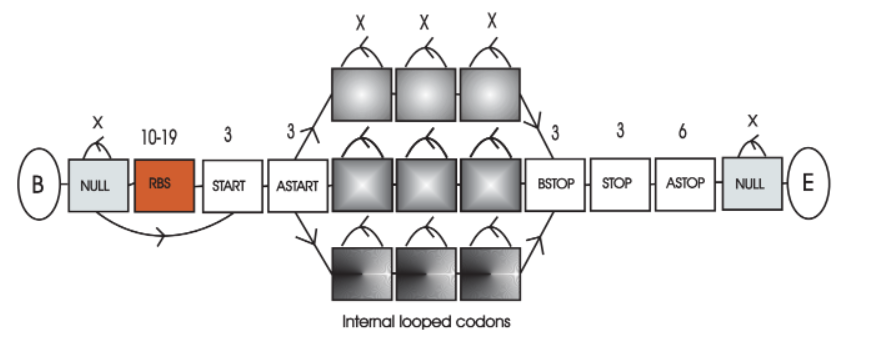</center>

<center> <b>Figure 4: </b> Architecture of the HMM used by EasyGene. Each box is a submodel with multiple states [10].</center>

We run the same Salmonella plasmid sequence through [EasyGene](https://services.healthtech.dtu.dk/service.php?EasyGene-1.2) and compare to the list of known genes in the plasmid. The results of the EasyGene predictions are shown below:

<center>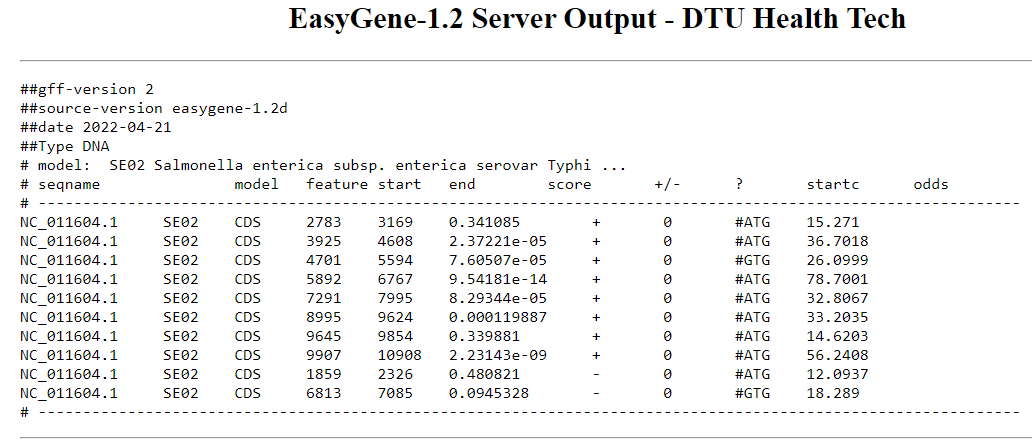</center>

<center> <b>Figure 5:</b> Results of Salmonella plasmid sequence in EasyGene. </center>

The important columns to observe here are the start, end, and score columns. The start and end columns show where the predicted genes start and end, while the score represents the statistical likelihood that gene is a protein coding gene. Comparing these results to the list of known genes, EasyGene was able to get 10 out of the 15 known genes within the plasmid. Corresponding to an accuracy of about 67% which is far better than just the simple ORF finder. Its failure to find the last 5 genes is likely because this model was trained on the *S. enterica* genome and not its plasmids which are more mutable (even containing DNA from other species).

<div class="alert alert-success">
    <center><h1> Summarizing Methods of Gene Prediction </h1></center>
</div>
 
Hopefully, you now have a better understanding of the basics to gene prediction. Most importantly, how difficult it is to develop an accurate model let alone implement said model. Nevertheless, it remains a crucial component of genome analysis and annotation. 

Below we summarize the methods discussed in terms of their pros and cons. 

<table style="font-size:16px">
  <tr>
    <th></th>
    <th>BLAST</th>
    <th>ORF Finder</th>
    <th>HMM</th>
  </tr>
  <tr>
    <td><b>Pros</b></td>
    <td>
      <ul>
        <li>No complex model or training required</li>
        <li>Only requires the existence of sufficient homology</li>
        <li>Can be used to determine gene/protein function</li>
      </ul>
    </td>
    <td>
      <ul>
        <li>Simple way of determing gene candidates</li>
        <li>No training required</li>
        <li>Works well in prokaryotes</li>
      </ul>
    </td>
    <td>
      <ul>
        <li>Can predict gene structure in addition to location</li>
        <li>Not limited to protein coding genes</li>
        <li>Works for prokaryotes and eukaryotes</li>
      </ul>
    </td>
  </tr>
  <tr>
    <td><b>Cons</b></td>
    <td>
      <ul>
        <li>Dependency on sufficient homology means many genes <br>might be missed in an uncharacterized genome</li>
      </ul>
    </td>
    <td>
      <ul>
        <li>Doesn't work well in eukaryotes</li>
        <li>Most results won't correspond to genes</li>
        <li>Only works for protein coding genes</li>
      </ul>
    </td>
    <td>
      <ul>
        <li>Requires a lot of training data</li>
        <li>Requires construction of a complex model</li>
        <li>Specific to a single type of organism(s)</li>
      </ul>
    </td>
  </tr>
</table>

<center> <b> Table 2: </b> Summary of gene prediction techniques. </center>



---
1.   Z Wang, Y Chen, Y Li. A Brief Review of Computational Gene Prediction    Methods. *Geno. Prot. Bioinfo.* **2**, (2004).
2. Kang Wenjing, Friedländer Marc R. Computational Prediction of miRNA Genes from Small RNA Sequencing Data. *Frontiers in Bioengineering and Biotechnology* **3**, (2015).   
3. NJ Dimonaco, W Aubrey, K Kenobi, et al. No one tool to rule them all: prokaryotic gene prediction tool annotations are highly dependent on the organism of study. *Bioinformatics* **38**, 1198–1207 (2022). 
4. M Brent. How does eukaryotic gene prediction work?. *Nat Biotechnol* **25**, 883–885 (2007).
5. C Kingsford, AL. Delcher, SL Salzberg. A Unified Model Explaining the Offsets of Overlapping and Near-Overlapping Prokaryotic Genes. *Molecular Biology and Evolution* **24**, 2091–2098 (2007). 
6. S Joseph. Ribosomal RNAs and Protein Synthesis. *Encyclopedia of Cell Biology* **1**, 384-395 (2016).
7. B Yoon. Hidden Markov Models and their Applications in Biological Analysis. *Current Genomics* **10**, 402-415 (2009).
8. A Churbanov, S Winters-Hilt. Implementing EM and Viterbi algorithms for Hidden Markov Model in linear memory. *BMC Bioinformatics* **9**, 224 (2008). 
9. D Kulp, D Haussler, MG Reese, FH Eeckman. A generalized hidden Markov model for the recognition of human genes in DNA. *Proc Int Conf Intell Syst Mol Biol* **4**, 134-142 (1996).
10. TS Larsen, A Krogh. EasyGene – a prokaryotic gene finder that ranks ORFs by statistical significance. *BMC Bioinformatics* **4**, 21 (2003). 

